# Predict using SageMaker Endpoint

## Model:  MobileNet (v1) SSD  300x300
## Trained For:  CFA Product Images



In [13]:
import os, sys
import json
import numpy as np
import cv2

import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# This is needed to display the images.
%matplotlib inline

## Global Variables

In [3]:
PROJECT_DIR = os.getcwd()
IMAGE_DIR = os.path.join(PROJECT_DIR, "data/new_jpeg_images")

MODEL_PATH = os.path.join(PROJECT_DIR, "trained_model/export/Servo/1564865938")
LABEL_MAP = os.path.join(PROJECT_DIR, "code/cfa_prod_label_map.pbtxt")

# you can get data using the TrainModel_Step1_Local notebook
TEST_TFRECORDS_PATH =  os.path.join(PROJECT_DIR, "code/tfrecords/test/")
                                    
SAMPLE_IMAGE = "/home/ec2-user/SageMaker/ssd-dag/data/jpeg_images/20190710_variety_1562781002.jpg"

# NAME - get this from the console
ENDPOINT_NAME = "ep-mobilenet-ssd"

## Get a Sample Image

(-0.5, 299.5, 299.5, -0.5)

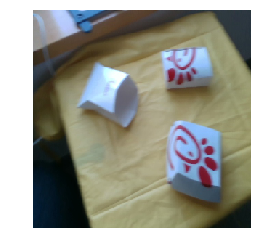

In [4]:
img = tf.keras.preprocessing.image.load_img(SAMPLE_IMAGE, target_size=[300, 300])
plt.imshow(img)
plt.axis('off')

In [5]:
x = tf.keras.preprocessing.image.img_to_array(img)
print (type(x), x.shape)

x32 = tf.keras.applications.mobilenet.preprocess_input(x[tf.newaxis,...])
print ("x32:", type(x32), x32.shape, x32.dtype)

x8 = x32.astype(np.uint8)
print ("x8:", type(x8), x8.shape, x8.dtype)

img_raw = tf.io.read_file(SAMPLE_IMAGE)
print ("tf.io.read_file:", img_raw)

img_tensor = repr(img_raw)
print ("repr:", type(img_tensor))

<class 'numpy.ndarray'> (300, 300, 3)
x32: <class 'numpy.ndarray'> (1, 300, 300, 3) float32
x8: <class 'numpy.ndarray'> (1, 300, 300, 3) uint8
tf.io.read_file: Tensor("ReadFile:0", shape=(), dtype=string)
repr: <class 'str'>


## Local Model

Local Model was pulled from a successful SageMaker training job (S3 -> local) and extracted.   This verifies the training job:
- created a saved_model.pb
- in export/Servo/

And, we can read the Signature Defs

In [6]:
print ("Loading saved_model.py from:", MODEL_PATH)
loaded_model = tf.saved_model.load(sess=tf.Session(), 
                                   tags=[tf.saved_model.tag_constants.SERVING], 
                                   export_dir=MODEL_PATH)

W0814 15:17:28.194376 139910510630720 deprecation.py:323] From <ipython-input-6-47e052c13399>:4: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Loading saved_model.py from: /home/ec2-user/SageMaker/ssd-dag/trained_model/export/Servo/1564865938


W0814 15:17:29.278669 139910510630720 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1282: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [7]:
# this model complies to serving framework and can read signature defs
!saved_model_cli show --dir {MODEL_PATH} --tag_set serve 

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "serving_default"
SignatureDef key: "tensorflow/serving/predict"


In [8]:
# Signatures for:
# - serving_default
# - tensorflow/serving/predict
# appear to be the same
!saved_model_cli show --dir {MODEL_PATH} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['serialized_example'] tensor_info:
      dtype: DT_STRING
      shape: ()
      name: tf_example:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['detection_boxes'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 100, 4)
      name: detection_boxes:0
  outputs['detection_classes'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 100)
      name: detection_classes:0
  outputs['detection_multiclass_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 100, 12)
      name: detection_multiclass_scores:0
  outputs['detection_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 100)
      name: detection_scores:0
  outputs['num_detections'] tensor_info:
      dtype: DT_FLOAT
      shape: (1)
      name: num_detections:0
  outputs['raw_detection_boxes'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 1917, 4)
      name: raw_detection_boxes:0
  outputs['raw_dete

## SageMaker Endpoint

In [9]:
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.predictor import json_serializer, json_deserializer

sagemaker_session = sagemaker.Session()
predictor=sagemaker.tensorflow.model.TensorFlowPredictor(ENDPOINT_NAME, sagemaker_session)

print (type(predictor))

<class 'sagemaker.tensorflow.model.TensorFlowPredictor'>


In [10]:
image_tensor = tf.constant(value=x8, shape=(1, 300, 300, 3), dtype=tf.uint8, name="tf_example")
# image_tensor = tf.constant(value=x32, shape=(1, 300, 300, 3), dtype=tf.float32, name="tf_example")
print (image_tensor)

Tensor("tf_example_1:0", shape=(1, 300, 300, 3), dtype=uint8)


## You Need a tf.Example


In [ ]:
# This is needed since we cloned tensorflow/models under code.
cwd = os.getcwd()
models = os.path.join(cwd, 'code/models/research/')
slim = os.path.join(cwd, 'code/models/research/slim')
sys.path.append(models)
sys.path.append(slim)

from object_detection.inference import detection_inference

! ls {TEST_TFRECORDS_PATH}
input_tfrecord_paths = [TEST_TFRECORDS_PATH]
serialized_example_tensor, image_tensor = detection_inference.build_input( input_tfrecord_paths)

print ("serialized_example_tensor", serialized_example_tensor)
print ("image_tensor", image_tensor.shape)

In [ ]:
%%time
print ("data type:", type(x8))
data=  np.random.randn(1, 784)
# Object of type 'Tensor' is not JSON serializable
# - so it must be looking for JSON
# output_dict = predictor.predict(image_tensor)  

# Tensor not serializable
# output_dict = predictor.predict({"tf_example": image_tensor})

# ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: 
#  Received client error (400) from model with message 
#  "{ "error": "Failed to process element: 0 key: tf_example of 'instances' list. 
#   Error: Invalid argument: JSON object: does not have named input: tf_example" }". 
# See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/ep-mobilenet-ssd 
# in account 586454201570 for more information.
# output_dict = predictor.predict({"tf_example": x8})

# ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: 
#  Received client error (400) from model with message 
#  "{ "error": "Failed to process element: 0 key: serialized_example of 'instances' list. 
#  Error: Invalid argument: JSON Value: 0 Type: Number is not of expected type: string" }". 
#  See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/ep-mobilenet-ssd 
#  in account 586454201570 for more information.
# output_dict = predictor.predict({"serialized_example": data})

# ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: 
# Received client error (400) from model with message 
# "{ "error": "Could not parse example input, value: \'<tf.Tensor \'ReadFile:0\' 
#    shape=() dtype=string>\'\n\t [[{{node ParseSingleExample/ParseSingleExample}}]]\n\t 
#  [[{{node case/cond/cond_jpeg/Switch}}]]" }". See https://us-east-1.console.aws.amazon.com/
# cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/
# Endpoints/ep-mobilenet-ssd in account 586454201570 for more information.
output_dict = predictor.predict({"serialized_example": img_tensor})

In [11]:
data_json = json.dumps({"signature_name": "serving_default", "instances": x32})

TypeError: Object of type 'ndarray' is not JSON serializable

In [16]:
image = cv2.imread(SAMPLE_IMAGE, 1)

# resize, as our model is expecting images in 32x32.
# image = cv2.resize(image, (32, 32))
image = cv2.resize(image, (300,300))
print ("data type:", type(image), image.shape)
#image = x32

data = {'instances': np.asarray(image).astype(float).tolist()}

# The request and response format is JSON for TensorFlow Serving.
# For more information: https://www.tensorflow.org/serving/api_rest#predict_api
predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

# For more information on the predictor class.
# https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/predictor.py
predictor.predict(data)

data type: <class 'numpy.ndarray'> (300, 300, 3)


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "{ "error": "Failed to process element: 0 of 'instances' list. Error: Invalid argument: JSON Value: 142.0 Type: Number is not of expected type: string" }". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/ep-mobilenet-ssd in account 586454201570 for more information.